In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from base_learning import BaseLearningAlgorithm
from os.path import join
from learning_algorithms import *

RAW_DATA_PATH = r"C:\Users\shami\OneDrive\Desktop\Master_Thesis_Data\Raw_Data"
PREPARED_DATA_PATH = r"C:\Users\shami\OneDrive\Desktop\Master_Thesis_Data\Prepared_Datasets"
TEST_DATA_PATH = r"C:\Users\shami\OneDrive\Desktop\Master_Thesis_Data\Test_Datasets"
TRAIN_DATA_PATH = r"C:\Users\shami\OneDrive\Desktop\Master_Thesis_Data\Train_Datasets"

In [3]:
import xgboost as xgb

In [5]:
df_train = pd.read_excel(join(TRAIN_DATA_PATH,"cc_fraud_2_train.xlsx"))
df_test = pd.read_excel(join(TEST_DATA_PATH,"cc_fraud_2_test.xlsx"))

In [3]:
s = SVMClassifier()

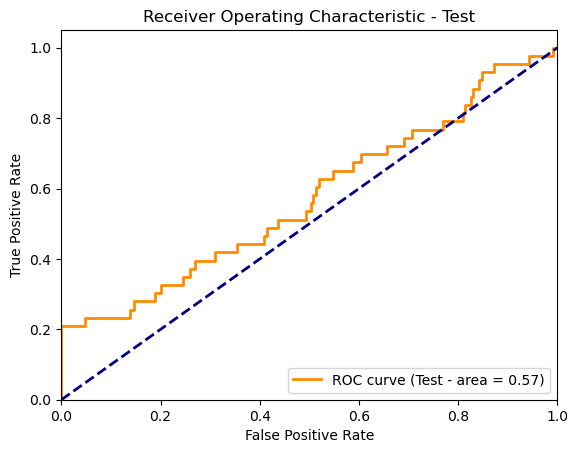

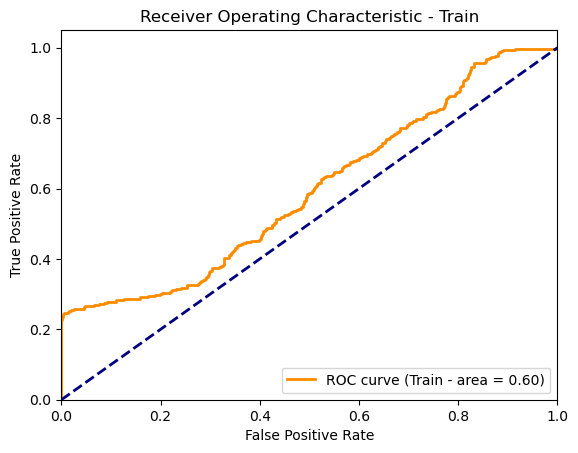

,Model,Dataset,Accuracy,F1 Score,Precision,Recall,AUC Score
0,SimpleSVC,Train,0.97972,0.0,0.0,0.0,0.595426
1,SimpleSVC,Test,0.98252,0.0,0.0,0.0,0.574583


In [4]:
s.train_eval(df_train.drop("Class",axis=1), df_train["Class"], df_test.drop("Class",axis=1), df_test["Class"])

In [5]:
s2 = SVMClassifier(class_weight='balanced')

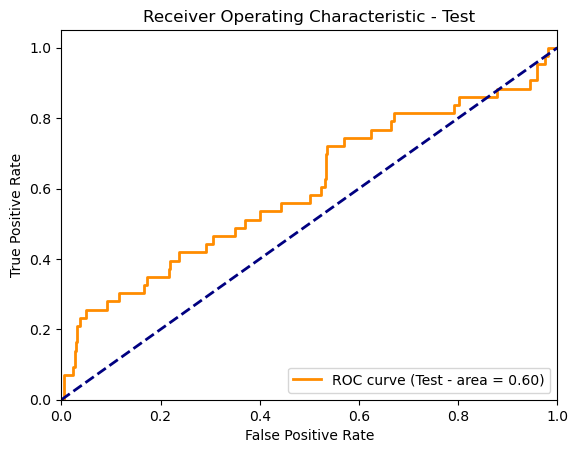

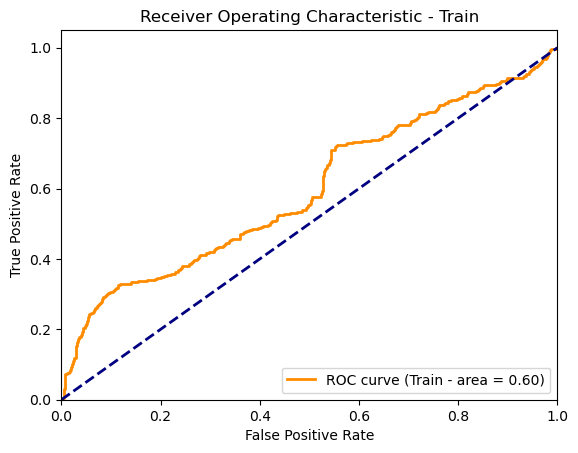

,Model,Dataset,Accuracy,F1 Score,Precision,Recall,AUC Score
0,SimpleSVC,Train,0.460885,0.050589,0.026231,0.708241,0.596118
1,SimpleSVC,Test,0.456504,0.044317,0.022861,0.720930,0.600543


In [6]:
s2.train_eval(df_train.drop("Class",axis=1), df_train["Class"], df_test.drop("Class",axis=1), df_test["Class"])

In [12]:
def get_scale_weight(y:np.array)->float:
    vc = y.value_counts()
    return vc.max()/vc.min()

get_scale_weight(df_train["Class"])


48.30957683741648

In [13]:
class XGBoostClassifier(BaseLearningAlgorithm):
    """XGBoost Classifier implementation of the BaseLearningAlgorithm."""
    
    def __init__(self, alg_name='SimpleXGB', max_depth=3, learning_rate=0.1, 
                 n_estimators=100, verbosity=0, objective='binary:logistic', 
                 booster='gbtree', class_weight=1):
        self.model = xgb.XGBClassifier(max_depth=max_depth, 
                                       learning_rate=learning_rate, 
                                       n_estimators=n_estimators, 
                                       verbosity=verbosity, 
                                       objective=objective, 
                                       booster=booster, 
                                       use_label_encoder=False, 
                                       scale_pos_weight=class_weight)
        self.alg_name = alg_name
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.verbosity = verbosity
        self.objective = objective
        self.booster = booster
        self.class_weight = class_weight

    def fit(self, x_train: pd.DataFrame, y_train: np.array, x_val: pd.DataFrame = None, y_val: np.array = None) -> None:
        """Fit the XGBoost model to the training data."""
        self.model.fit(x_train, y_train, eval_metric='logloss')

    def predict(self, x_test: pd.DataFrame) -> np.array:
        """Predict using the fitted XGBoost model."""
        return self.model.predict(x_test)

    def train_eval(self, x_train: pd.DataFrame, y_train: np.array, x_test: pd.DataFrame, y_test: np.array, x_val: pd.DataFrame = None, y_val: np.array = None, save_model: bool = True) -> pd.DataFrame:
        """Train and evaluate the XGBoost model on both training and test datasets."""
        self.fit(x_train, y_train, x_val, y_val)

        predictions_test = self.predict(x_test)
        probabilities_test = self.model.predict_proba(x_test)[:, 1]

        predictions_train = self.predict(x_train)
        probabilities_train = self.model.predict_proba(x_train)[:, 1]

        # Evaluation metrics for test data
        f1_test = f1_score(y_test, predictions_test, zero_division=0)
        accuracy_test = accuracy_score(y_test, predictions_test)
        precision_test = precision_score(y_test, predictions_test, zero_division=0)
        recall_test = recall_score(y_test, predictions_test, zero_division=0)
        auc_score_test = roc_auc_score(y_test, probabilities_test)

        # Evaluation metrics for train data
        f1_train = f1_score(y_train, predictions_train, zero_division=0)
        accuracy_train = accuracy_score(y_train, predictions_train)
        precision_train = precision_score(y_train, predictions_train, zero_division=0)
        recall_train = recall_score(y_train, predictions_train, zero_division=0)
        auc_score_train = roc_auc_score(y_train, probabilities_train)

        # Plot ROC curve for both test and train data
        self.plot_roc_curve(y_test, probabilities_test, 'Test')
        self.plot_roc_curve(y_train, probabilities_train, 'Train')

        evaluation_report = pd.DataFrame({
            'Model': [self.alg_name, self.alg_name],
            'Dataset': ['Train', 'Test'],
            'Accuracy': [accuracy_train, accuracy_test],
            'F1 Score': [f1_train, f1_test],
            'Precision': [precision_train, precision_test],
            'Recall': [recall_train, recall_test],
            'AUC Score': [auc_score_train, auc_score_test]
        })

        return evaluation_report

    def plot_roc_curve(self, y_true: np.array, probabilities: np.array, dataset_label: str) -> None:
        """Plot the ROC curve for a given dataset."""
        fpr, tpr, _ = roc_curve(y_true, probabilities)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve ({dataset_label} - area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - {dataset_label}')
        plt.legend(loc="lower right")
        plt.show()

    @property
    def name(self) -> str:
        """Return the name of the algorithm."""
        return f"{self.alg_name}_{self.booster}_depth{self.max_depth}_lr{self.learning_rate}_est{self.n_estimators}"

In [14]:
x = XGBoostClassifier()

C:\Users\shami\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


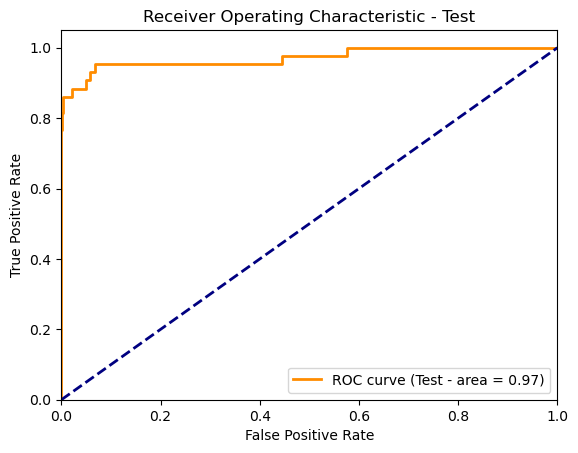

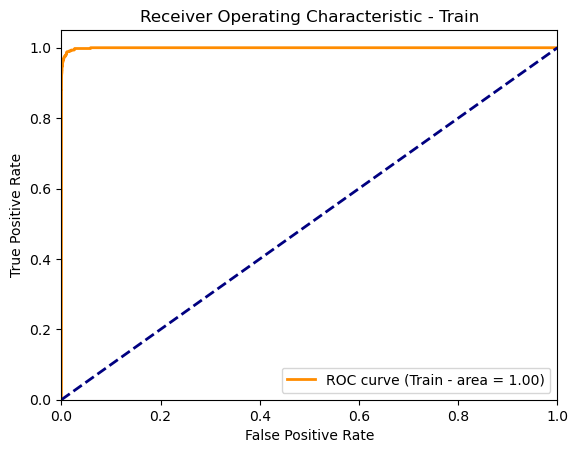

,Model,Dataset,Accuracy,F1 Score,Precision,Recall,AUC Score
0,SimpleXGB,Train,0.997425,0.933020,0.987562,0.884187,0.999400
1,SimpleXGB,Test,0.995528,0.860759,0.944444,0.790698,0.971452


In [15]:
x.train_eval(df_train.drop("Class",axis=1), df_train["Class"], df_test.drop("Class",axis=1), df_test["Class"])

In [17]:
x2 = XGBoostClassifier(alg_name="XGB_Class_Weights", class_weight=get_scale_weight(df_train["Class"]))

C:\Users\shami\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


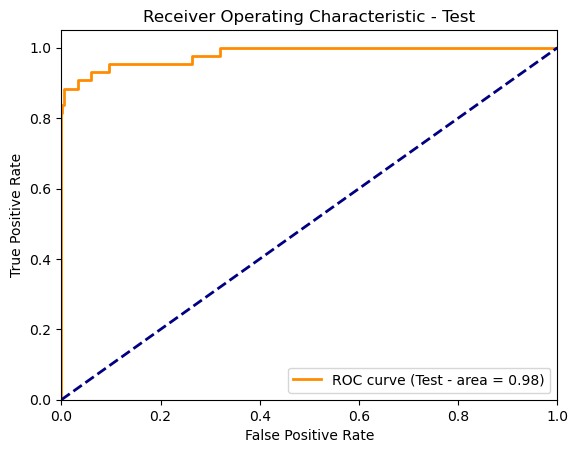

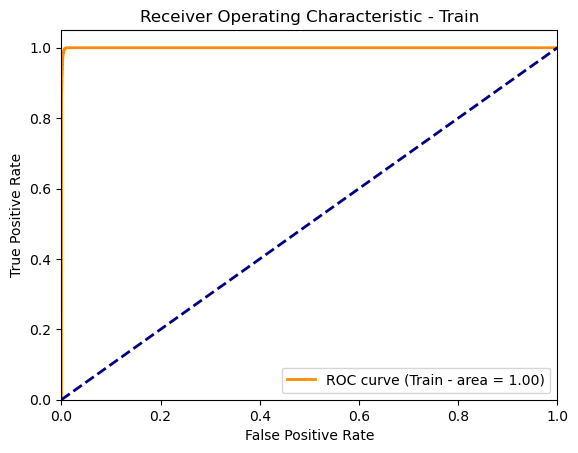

,Model,Dataset,Accuracy,F1 Score,Precision,Recall,AUC Score
0,XGB_Class_Weights,Train,0.994038,0.871345,0.774697,0.995546,0.999670
1,XGB_Class_Weights,Test,0.989431,0.745098,0.644068,0.883721,0.981805


In [18]:
x2.train_eval(df_train.drop("Class",axis=1), df_train["Class"], df_test.drop("Class",axis=1), df_test["Class"])